# CAPÍTULO 3: Regresión

*Noemi González Lois*

**MÓDULOS**

In [1]:
# Importación de módulos necesarios
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Ignorar advertencias de futuras versiones
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

CARGAMOS Y VISUALIZAMOS LOS DATOS DE LA BASE

In [2]:
datos = pd.read_csv('BaseDatos_mod.csv', delimiter=',')
datos.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,3,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,3,1


MATRIZ DE CORRELACIÓN LINEAL

In [3]:
datos.corr()

,BI-RADS,Age,Shape,Margin,Density,Severity
BI-RADS,1.000000,0.338493,0.448287,0.467755,0.089451,0.569035
Age,0.338493,1.000000,0.360532,0.402995,0.021119,0.431329
Shape,0.448287,0.360532,1.000000,0.718893,0.057495,0.552781
Margin,0.467755,0.402995,0.718893,1.000000,0.094516,0.557867
Density,0.089451,0.021119,0.057495,0.094516,1.000000,0.054681
Severity,0.569035,0.431329,0.552781,0.557867,0.054681,1.000000


In [4]:
# ESTABLECEMOS EL TARGET 'Y' Y LOS DEMÁS DATOS 'X'
# Seleccionamos la columna 'Shape' como nuestro objetivo (y)
target = datos['Shape']

# Convertimos el DataFrame de pandas en un array numpy
y = np.ravel(target)

# Seleccionamos las columnas 'Margin' y 'Severity' como nuestras características (X)
# Eliminamos la columna 'Density' ya que no la estamos utilizando
data = datos[['Margin', 'Severity']]
X = np.array(data)

# SEPARAMOS EN TRAIN Y TEST
# Dividimos los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

# Extraemos los nombres de las columnas como atributos del subconjunto Train
features_train = list(X_train.columns)

In [5]:
target.head()

0    3
1    1
2    4
3    1
4    1
Name: Shape, dtype: int64

In [6]:
data.head()

,Margin,Severity
0,5,1
1,1,1
2,5,1
3,1,0
4,5,1


TABLA COMPARATIVA

In [7]:
# Creamos un DataFrame para comparar los resultados de diferentes modelos
# Indexamos por el nombre del modelo ('Regresión lineal', 'KNN', 'Árbol')
# y las columnas representan diferentes métricas ('R2 test', 'R2 train', 'ECM', 'Varianza')
comp = pd.DataFrame(index=['Regresión lineal', 'KNN', 'Árbol'], 
                    columns=['R2 test', 'R2 train', 'Error cuadrático medio', 'Varianza'])

## REGRESIÓN LINEAL

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
# Creamos el objeto de Regresión Lineal y ajustamos el modelo
model = LinearRegression().fit(X_train, y_train)
predict = model.predict(X_test)

# Calculamos el R2 para el conjunto de TEST y TRAIN
r2_test = model.score(X_test, y_test).round(4)
r2_train = model.score(X_train, y_train).round(4)

# Calculamos la varianza explicada y el error cuadrático medio
var = explained_variance_score(y_test, predict).round(4)
ECM = mean_squared_error(y_test, predict).round(4)

# Imprimimos los resultados
print('El R2 para el modelo de regresión lineal en el conjunto de TEST es:', r2_test)
print('El R2 para el modelo de regresión lineal en el conjunto de TRAIN es:', r2_train)
print("Variance score:", var)
print("Mean squared error score (TEST):", ECM)

# Asignamos los resultados al DataFrame 'comp'
comp.loc['Regresión lineal'] = [r2_test, r2_train, ECM, var]

El R2 para el modelo de regresión lineal en el conjunto de TEST es: 0.4722
El R2 para el modelo de regresión lineal en el conjunto de TRAIN es: 0.5662
Variance score: 0.4771
Mean squared error score (TEST): 0.7701


## K VECINOS MÁS CERCANOS

Primero tenemos que **normalizar** los datos de X_train y estandarizarlos de X_test, ya que es un método basado en distancia. 

In [10]:
from sklearn.neighbors import KNeighborsRegressor

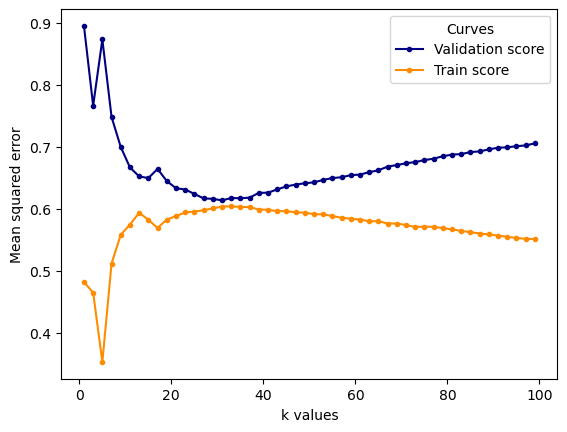

El valor k óptimo es: 31


In [11]:
# Copiar los datos para evitar modificar los originales
X_train_std = np.copy(X_train)
X_test_std = np.copy(X_test)

# Estandarizar TRAIN y TEST usando el mismo scaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_std)
X_test_std = scaler.fit_transform(X_test_std)

# Definir los valores de k para la búsqueda
k_values = range(1, 101, 2)

# Inicializar listas para almacenar los resultados
mean_scores = []  # Almacena los puntajes medios de validación cruzada
scores_train = []  # Almacena los puntajes de entrenamiento

# Bucle sobre los valores de k
for k in k_values:
    # Inicializar un modelo KNeighborsRegressor con el valor actual de k
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Calcular los puntajes de validación cruzada negativos del modelo
    scores = -cross_val_score(knn, X_train_std, np.ravel(y_train), cv=5, scoring='neg_mean_squared_error')
    
    # Calcular el puntaje medio de validación cruzada y almacenarlo
    mean_scores.append(scores.mean())
    
    # Entrenar el modelo KNeighborsRegressor en los datos de entrenamiento
    knn_train = KNeighborsRegressor(n_neighbors=k)
    model = knn_train.fit(X_train_std, np.ravel(y_train))
    
    # Predecir en los datos de entrenamiento y calcular el puntaje de entrenamiento
    model.predict(X_train_std)
    score = model.score(X_train_std, y_train)
    scores_train.append(score)

# Graficar las curvas de validación y entrenamiento
fig, ax = plt.subplots()
ax.plot(k_values, mean_scores, color="navy", label="Validation score", marker='.')
ax.plot(k_values, scores_train, color="darkorange", label="Train score", marker='.')
ax.legend(loc="best", title="Curves", frameon=True)
plt.xlabel('k values')
plt.ylabel('Mean squared error')
plt.show()

# Encontrar el valor k óptimo que minimiza el error cuadrático medio
k = np.array(k_values)[np.argmin(mean_scores)]
print('El valor k óptimo es:', k)

In [12]:
#Entrenamos el modelo con el valor óptimo de k obtenido.
model = KNeighborsRegressor(n_neighbors=k)
predict= model.fit(X_train_std, np.ravel(y_train)).predict(X_test_std)

In [13]:
# Calcular el R2 para el conjunto de test y el conjunto de train
r2_test = model.score(X_test_std, y_test).round(4)
r2_train = model.score(X_train_std, y_train).round(4)
var = explained_variance_score(y_test, predict).round(4)
mse = mean_squared_error(y_test, predict).round(4)

# Calcular la varianza y el R2 score
print("=============== Regressor Report ================")
print('El R2 para el modelo de KNN en el conjunto de TEST es:', r2_test)
print('El R2 para el modelo de KNN en el conjunto de TRAIN es:', r2_train,'\n')
print("Variance score:", var)
print("Mean squared error score:", mse)

# Asignamos los resultados al DataFrame 'comp'
comp.loc['KNN'] = [r2_test, r2_train, ECM, var]

=============== Regressor Report ================
El R2 para el modelo de KNN en el conjunto de TEST es: 0.5152
El R2 para el modelo de KNN en el conjunto de TRAIN es: 0.6035 

Variance score: 0.5171
Mean squared error score: 0.7073


## ÁRBOLES DE REGRESIÓN

In [14]:
from sklearn.tree import DecisionTreeRegressor

Los parámetros seleccionados por la función GridSearch son: {'max_depth': 5, 'min_samples_leaf': 10}


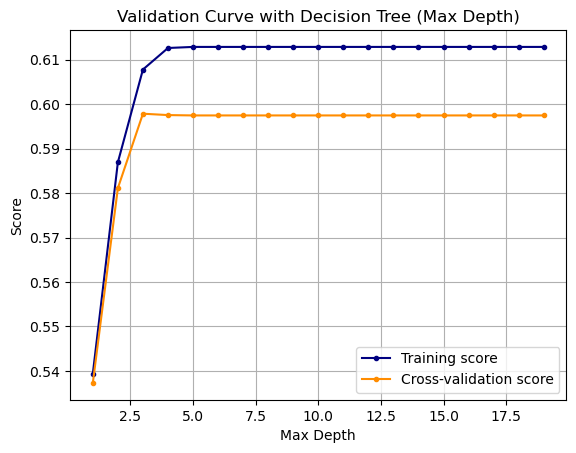

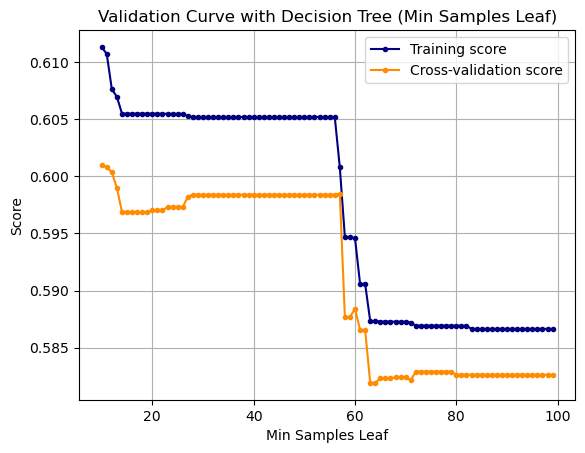

In [15]:
# Creamos el modelo DecisionTreeRegressor
model = DecisionTreeRegressor()

# Definimos los rangos de parámetros para la búsqueda de hiperparámetros
max_depth = range(1, 20)
min_samples_leaf = range(10, 100)

# Definimos el diccionario de parámetros para GridSearchCV
param = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

# Realizamos la búsqueda de hiperparámetros
grid = GridSearchCV(model, param_grid=param, cv=5, n_jobs=-1)
fit = grid.fit(X_train, y_train)
best_parameters = fit.best_params_
print('Los parámetros seleccionados por la función GridSearch son:', best_parameters)

# Realizamos las predicciones usando el mejor modelo encontrado por GridSearchCV
predict = grid.predict(X_test)

# Validación de la curva para el parámetro "max_depth"
train_scores, test_scores = validation_curve(model, X_train, y_train, param_name="max_depth", param_range=max_depth, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficamos la curva de validación para "max_depth"
plt.title("Validation Curve with Decision Tree (Max Depth)")
plt.xlabel('Max Depth')
plt.ylabel("Score")
plt.plot(max_depth, train_scores_mean, label="Training score", color="navy", marker='.')
plt.plot(max_depth, test_scores_mean, label="Cross-validation score", color="darkorange", marker='.')
plt.grid()
plt.legend(loc="best")
plt.show()

# Validación de la curva para el parámetro "min_samples_leaf"
train_scores, test_scores = validation_curve(model, X_train, y_train, param_name="min_samples_leaf", param_range=min_samples_leaf, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficamos la curva de validación para "min_samples_leaf"
plt.title("Validation Curve with Decision Tree (Min Samples Leaf)")
plt.xlabel('Min Samples Leaf')
plt.ylabel("Score")
plt.plot(min_samples_leaf, train_scores_mean, label="Training score", color="navy", marker='.')
plt.plot(min_samples_leaf, test_scores_mean, label="Cross-validation score", color="darkorange", marker='.')
plt.grid()
plt.legend(loc="best")
plt.show()


In [16]:
# Calcular el R2 para el conjunto de test y el conjunto de train
r2_test = grid.score(X_test, y_test).round(4)
r2_train = grid.score(X_train, y_train).round(4)

# Calcular la varianza y el error cuadrático medio
var = explained_variance_score(y_test, predict).round(4)
mse = mean_squared_error(y_test, predict).round(4)

# Imprimir el reporte del modelo
print("=============== Regressor Report ================")
print('El R2 para el modelo de árboles de decisión en el conjunto de TEST es:', r2_test)
print('El R2 para el modelo de árboles de decisión en el conjunto de TRAIN es:', r2_train, '\n')
print("Variance score:", var)
print("Mean squared error score:", mse)

# Asignar los resultados al DataFrame 'comp'
comp.loc['Árbol'] = [r2_test, r2_train, mse, var]

=============== Regressor Report ================
El R2 para el modelo de árboles de decisión en el conjunto de TEST es: 0.5148
El R2 para el modelo de árboles de decisión en el conjunto de TRAIN es: 0.6115 

Variance score: 0.5198
Mean squared error score: 0.7078


## COMPARACIÓN DE RESULTADOS

In [17]:
comp

,R2 test,R2 train,Error cuadrático medio,Varianza
Regresión lineal,0.4722,0.5662,0.7701,0.4771
KNN,0.5152,0.6035,0.7701,0.5171
Árbol,0.5148,0.6115,0.7078,0.5198
